In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(tf.__version__)

1.12.0


## 数据导入
这里我们有两种导入方式，一种是使用keras自带的函数进行
二是直接去下载数据集然后导入，我们这里依旧使用第二种方式
虽然此处我们借鉴了Tensorflow中文档的代码，但是为了保持代码风格，我们依旧采用“x_train, y_train, x_test, y_test"的数据集命名方式。

In [8]:
# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

fashion_mnist = input_data.read_data_sets("G:/Data/image/fashion_mnist/", one_hot=True)

x_train, y_train = fashion_mnist.train.images, fashion_mnist.train.labels
x_test, y_test = fashion_mnist.test.images, fashion_mnist.train.labels
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Instructions for updating:
Please use tf.data to implement this functionality.
Extracting G:/Data/image/fashion_mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting G:/Data/image/fashion_mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting G:/Data/image/fashion_mnist/t10k-images-idx3-ubyte.gz
Extracting G:/Data/image/fashion_mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [10]:
print(x_train.shape)
print(len(y_train))
print(len(y_test))

(55000, 28, 28, 1)
55000
55000


但是在进行数据数量的探索之后，我们发现tensorflow默认的mnist加载器之加载了55000个数据样本，或许我们需要修改一下以前的旧思维，试试在线版本了。当然了10%的样本数量的减少实际上对我们之后的代码运行根本没有任何不好的影响。只是作者比较强迫症而已。

## 在线加载数据集
加载数据集这里有两种方式，在线加载或者本地加载。此处我们使用在线加载第一次加载时候会浪费一定的时间，但是之后将不存在这个问题。

In [11]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 163s 37us/step


In [12]:
train_images.shape

(60000, 28, 28)

In [14]:
len(train_labels)

60000

In [15]:
len(test_labels)

10000

## 预处理数据集

必须先对数据进行预处理，然后再训练网络。如果您检查训练集中的第一张图像，就会发现像素值介于 0 到 255 之间：

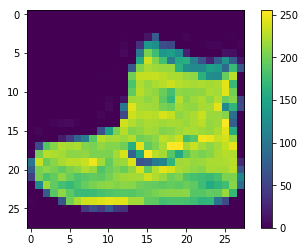

In [16]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

我们将这些值缩小到 0 到 1 之间，然后将其馈送到神经网络模型。为此，将图像组件的数据类型从整数转换为浮点数，然后除以 255。以下是预处理图像的函数：

务必要以相同的方式对训练集和测试集进行预处理


然后再显示训练集中的前 25 张图像，并在每张图像下显示类别名称。验证确保数据格式正确无误，然后我们就可以开始构建和训练网络了。

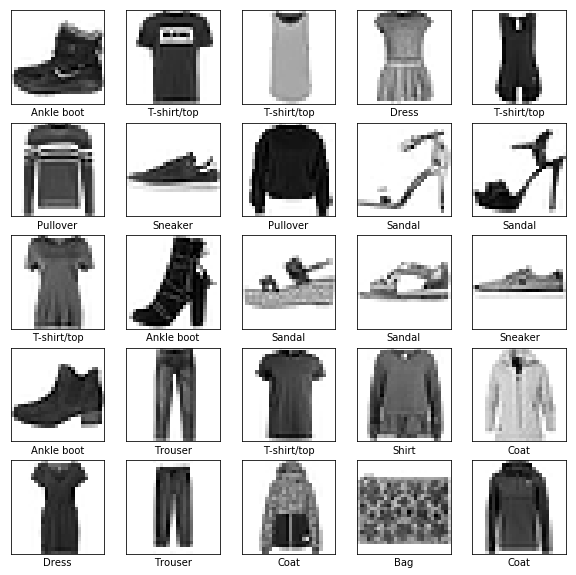

In [17]:
train_images = train_images / 255.0

test_images = test_images / 255.0

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## 构建模型
构建神经网络需要先配置模型的层，然后再编译模型。

### 设置层
神经网络的基本构造块是层。层从馈送到其中的数据中提取表示结果。希望这些表示结果有助于解决手头问题。

大部分深度学习都会把简单的层连在一起。大部分层（例如 tf.keras.layers.Dense）都具有在训练期间要学习的参数。

In [18]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

该网络中的第一层 tf.keras.layers.Flatten 将图像格式从二维数组（28x28 像素）转换成一维数组（28 * 28 = 784 像素）。可以将该层视为图像中像素未堆叠的行，并排列这些行。该层没有要学习的参数；它只改动数据的格式。

在扁平化像素之后，该网络包含两个 tf.keras.layers.Dense 层的序列。这些层是密集连接或全连接神经层。第一个 Dense 层具有 128 个节点（或神经元）。第二个（也是最后一个）层是具有 10 个节点的 softmax 层，该层会返回一个具有 10 个概率得分的数组，这些得分的总和为 1。每个节点包含一个得分，表示当前图像属于 10 个类别中某一个的概率。

### 编译模型
模型还需要再进行几项设置才可以开始训练。这些设置会添加到模型的编译步骤：

 - 损失函数 - 衡量模型在训练期间的准确率。我们希望尽可能缩小该函数，以“引导”模型朝着正确的方向优化。
 - 优化器 - 根据模型看到的数据及其损失函数更新模型的方式。
 - 指标 - 用于监控训练和测试步骤。以下示例使用准确率，即图像被正确分类的比例。

In [19]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 训练模型
训练神经网络模型需要执行以下步骤：
 1. 将训练数据馈送到模型中，在本示例中为 train_images 和 train_labels 数组。
 2. 模型学习将图像与标签相关联。
 3. 我们要求模型对测试集进行预测，在本示例中为 test_images 数组。我们会验证预测结果是否与 test_labels 数组中的标签一致。

    
要开始训练，请调用 model.fit 方法，使模型与训练数据“拟合”：

In [20]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 167s 3ms/step - loss: 0.5012 - acc: 0.8266
Epoch 2/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.3749 - acc: 0.8649
Epoch 3/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.3353 - acc: 0.8782
Epoch 4/5
60000/60000 [==============================] - 3s 55us/step - loss: 0.3130 - acc: 0.8851
Epoch 5/5
60000/60000 [==============================] - 3s 56us/step - loss: 0.2952 - acc: 0.8904


在模型训练期间，系统会显示损失和准确率指标。该模型在训练数据上的准确率达到 0.911（即 89.1%）。

## 评估准确率

接下来，比较一下模型在测试数据集上的表现：

In [21]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 39us/step
Test accuracy: 0.8773


结果表明，模型在测试数据集上的准确率略低于在训练数据集上的准确率。训练准确率和测试准确率之间的这种差异表示出现过拟合。如果机器学习模型在新数据上的表现不如在训练数据上的表现，就表示出现过拟合。

## 做出预测

模型经过训练后，我们可以使用它对一些图像进行预测。我们首先保存预测的结果，然后让我们来看看第一个预测：

In [22]:
predictions = model.predict(test_images)

predictions[0]

array([9.4533988e-07, 1.2607866e-10, 3.9219043e-07, 1.0890881e-07,
       6.8321060e-07, 6.0040623e-02, 5.4281020e-07, 9.7368099e-03,
       3.5504872e-06, 9.3021631e-01], dtype=float32)

预测结果是一个具有 10 个数字的数组。这些数字说明模型对于图像对应于 10 种不同服饰中每一个服饰的“置信度”。我们可以看到哪个标签的置信度值最大：

至于结果的话----模型非常确信这张图像是踝靴或属于 class_names[9]。然后我们可以检查测试标签以查看该预测是否正确：


In [23]:
print('我们的预测结果为:%d，而实际结果为:%d'%(np.argmax(predictions[0]),test_labels[0]))

我们的预测结果为:9，而实际结果为:9


我们还可以将该预测绘制成图来查看全部 10 个通道

In [24]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

我们来看看第 0 张图像、预测和预测数组。

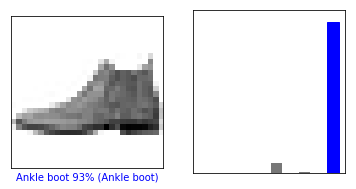

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

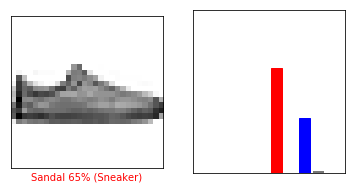

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

我们用它们的预测绘制几张图像。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。请注意，即使置信度非常高，也有可能预测错误。

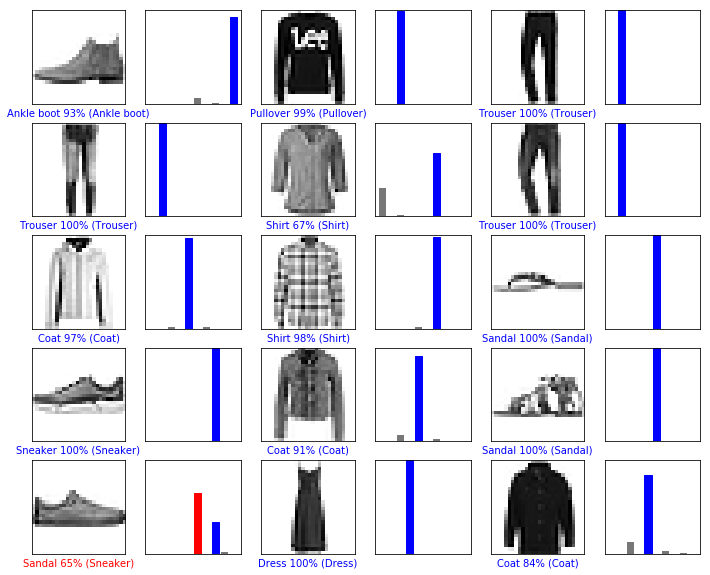

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

最后，使用经过训练的模型对单个图像进行预测。

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


tf.keras 模型已经过优化，可以一次性对样本批次或样本集进行预测。因此，即使我们使用单个图像，仍需要将其添加到列表中：`

In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


现在，预测这张图像：

In [30]:
predictions_single = model.predict(img)

print(predictions_single)

[[9.4533976e-07 1.2607890e-10 3.9219114e-07 1.0890879e-07 6.8321185e-07
  6.0040686e-02 5.4281122e-07 9.7368145e-03 3.5504936e-06 9.3021619e-01]]


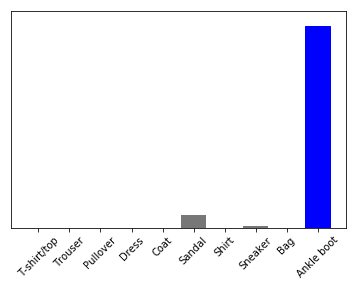

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

model.predict 返回一组列表，每个列表对应批次数据中的每张图像。（仅）获取批次数据中相应图像的预测结果：

In [32]:
np.argmax(predictions_single[0])

9

和刚才一样，模型预测的标签为 9。

In [33]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.